In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
import shap
warnings.filterwarnings("ignore")

In [115]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [116]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

# Data Cleaning

In [ ]:
# renaming columns
df.rename(columns={
    'age': 'Age',
    'job': 'Job',
    'marital': 'Marital_Status',
    'education': 'Education',
    'default': 'Credit_Default',
    'balance': 'Balance',
    'housing': 'Housing_Loan',
    'loan': 'Personal_Loan',
    'contact': 'Contact_Type',
    'day': 'Last_Contact_Day',
    'month': 'Last_Contact_Month',
    'duration': 'Last_Contact_Duration_Secs',
    'campaign': 'No_of_Contacts_This_Campaign',
    'pdays': 'Days_Since_Last_Contact',
    'previous': 'No_of_Previous_Contacts_Previous_Campaign',
    'poutcome': 'Previous_Campaign_Result',
    'y': 'Target'
}, inplace=True)

In [118]:
df.isnull().sum()

Age                                          0
Job                                          0
Marital_Status                               0
Education                                    0
Credit_Default                               0
Balance                                      0
Housing_Loan                                 0
Personal_Loan                                0
Contact_Type                                 0
Last_Contact_Day                             0
Last_Contact_Month                           0
Last_Contact_Duration_Secs                   0
No_of_Contacts_This_Campaign                 0
Days_Since_Last_Contact                      0
No_of_Previous_Contacts_Previous_Campaign    0
Previous_Campaign_Result                     0
Target                                       0
dtype: int64

In [119]:
# unique values in each categorical column
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique values")

Job: 12 unique values
Marital_Status: 3 unique values
Education: 4 unique values
Credit_Default: 2 unique values
Housing_Loan: 2 unique values
Personal_Loan: 2 unique values
Contact_Type: 3 unique values
Last_Contact_Month: 12 unique values
Previous_Campaign_Result: 4 unique values
Target: 2 unique values


In [ ]:
print(df['Job'].value_counts())

# admin. with admin
df['Job'] = df['Job'].replace('admin.', 'admin')

Job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64


In [121]:
# drop rows with unknown job
df = df[df['Job'] != 'unknown']

In [122]:
# unique values in the marital status column
print(df['Marital_Status'].value_counts())

Marital_Status
married     27011
single      12722
divorced     5190
Name: count, dtype: int64


In [123]:
# unique values in the Education column
print(df['Education'].value_counts())

Education
secondary    23131
tertiary     13262
primary       6800
unknown       1730
Name: count, dtype: int64


In [ ]:
df['Education'] = df['Education'].replace('unknown', 'primary')

In [125]:
# unique values in the Contact_Type column
print(df['Contact_Type'].value_counts())

Contact_Type
cellular     29154
unknown      12909
telephone     2860
Name: count, dtype: int64


In [126]:
# unique values in the Previous_Campaign_Result column
print(df['Previous_Campaign_Result'].value_counts())

Previous_Campaign_Result
unknown    36704
failure     4881
other       1838
success     1500
Name: count, dtype: int64


In [ ]:
df['Previous_Campaign_Result'] = df['Previous_Campaign_Result'].replace('other', 'unknown')

In [ ]:
# converting target variable to a binary variable
df['Target'] = df['Target'].replace({'yes': 1, 'no': 0})

# converting Default, Housing_Loan, and Personal_Loan to binary variables
df['Credit_Default'] = df['Credit_Default'].replace({'yes': 1, 'no': 0})
df['Housing_Loan'] = df['Housing_Loan'].replace({'yes': 1, 'no': 0})
df['Personal_Loan'] = df['Personal_Loan'].replace({'yes': 1, 'no': 0})

## EDA

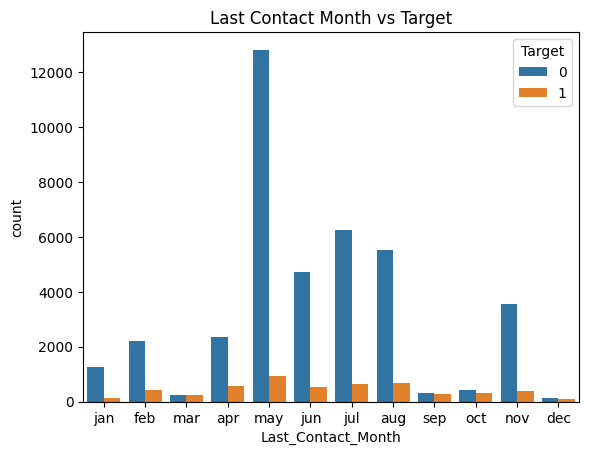

Chi²=3036.3371,  dof=11,  p-value=0.00000000
Last_Contact_Month
jan    0.100144
feb    0.165781
mar    0.521097
apr    0.195214
may    0.067128
jun    0.103790
jul    0.091200
aug    0.110446
sep    0.466667
oct    0.437414
nov    0.101365
dec    0.469484
Name: Target, dtype: float64


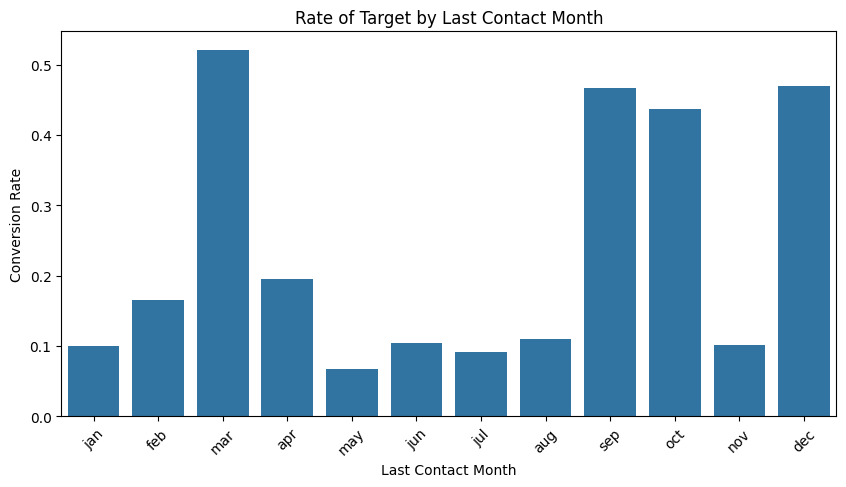

In [ ]:
# Calendar sequence for the x-axis
month_order = ['jan','feb','mar','apr','may','jun',
               'jul','aug','sep','oct','nov','dec']

df['Last_Contact_Month'] = (df['Last_Contact_Month']
                               .str.lower()       
                               .astype(pd.CategoricalDtype(
                                   categories=month_order,
                                   ordered=True)))


sns.countplot(x='Last_Contact_Month',
              hue='Target',
              data=df,
              order=month_order)     
plt.title('Last Contact Month vs Target')
plt.show()

# Chi-square test (categorical vs categorical)
ct  = pd.crosstab(df['Last_Contact_Month'], df['Target'])
chi2, p, dof, exp = ss.chi2_contingency(ct)
print(f"Chi²={chi2:.4f},  dof={dof},  p-value={p:.8f}")

# Conversion rate per month in calendar order
rate = (df.groupby('Last_Contact_Month')['Target']
          .mean()                      # proportion of 1’s (yes)
          .reindex(month_order))       

print(rate)

plt.figure(figsize=(10, 5))
sns.barplot(x=rate.index, y=rate.values, order=month_order)
plt.title('Rate of Target by Last Contact Month')
plt.xlabel('Last Contact Month')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.show()

In [130]:
# drop the Contact_Type column
df.drop(columns=['Contact_Type'], inplace=True)

# drop the Last_Contact_Day column
df.drop(columns=['Last_Contact_Day'], inplace=True)

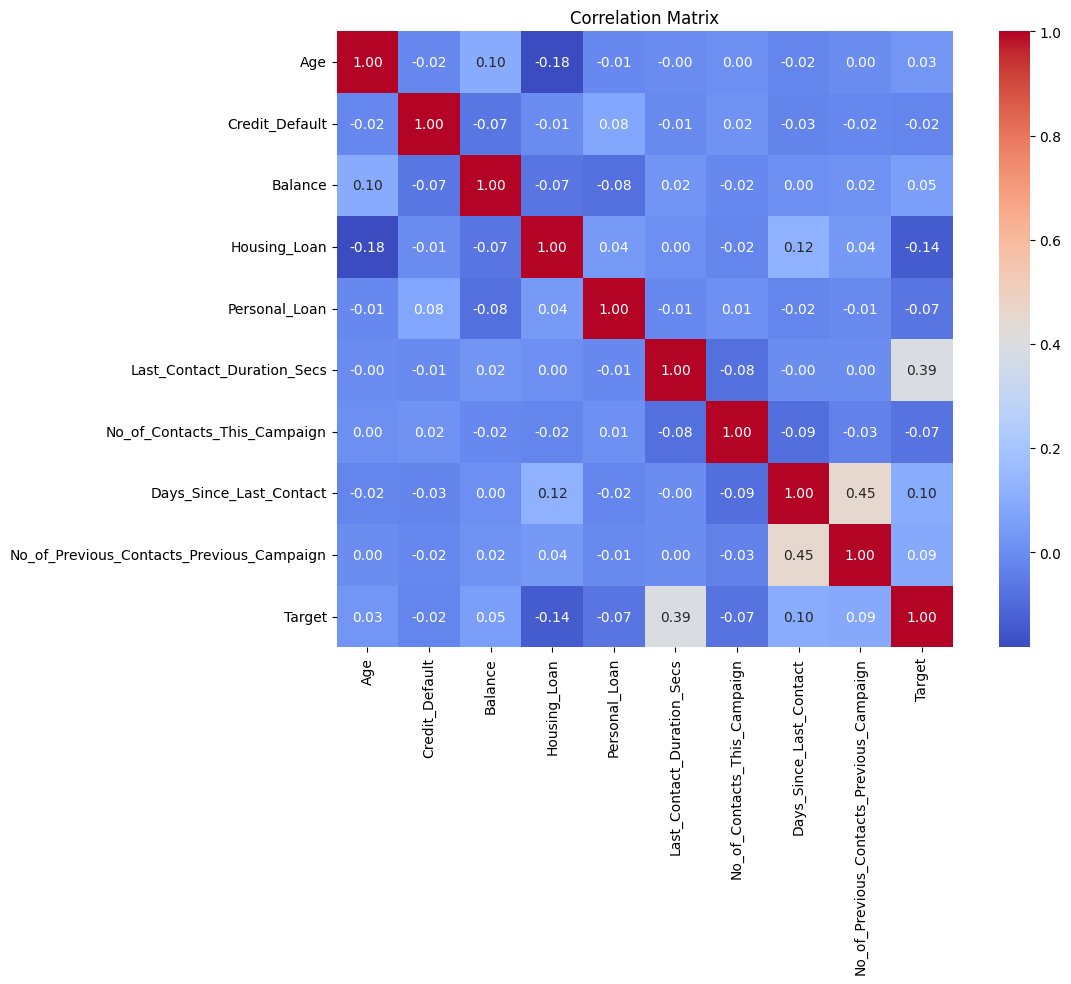

In [131]:
# correlation matrix of the numerical columns
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [132]:
scaler = StandardScaler()
# Age scaling
df['Age'] = scaler.fit_transform(df[['Age']])

# Balance scaling
df['Balance'] = scaler.fit_transform(df[['Balance']])

# Last_Contact_Duration_Secs scaling
df['Last_Contact_Duration_Secs'] = scaler.fit_transform(df[['Last_Contact_Duration_Secs']])

In [133]:
# separate the features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

y.value_counts()

Target
0    39668
1     5255
Name: count, dtype: int64

In [134]:
# categorical columns to one-hot encoding
X = pd.get_dummies(X, columns=['Job', 'Marital_Status', 'Last_Contact_Month', 'Previous_Campaign_Result'], drop_first=True) 

# education column to label encoding
X['Education'] = X['Education'].replace({'primary': 0, 'secondary': 1, 'tertiary': 2})

In [135]:
X.head()

,Age,Education,Credit_Default,Balance,Housing_Loan,Personal_Loan,Last_Contact_Duration_Secs,No_of_Contacts_This_Campaign,Days_Since_Last_Contact,No_of_Previous_Contacts_Previous_Campaign,...,Last_Contact_Month_may,Last_Contact_Month_jun,Last_Contact_Month_jul,Last_Contact_Month_aug,Last_Contact_Month_sep,Last_Contact_Month_oct,Last_Contact_Month_nov,Last_Contact_Month_dec,Previous_Campaign_Result_success,Previous_Campaign_Result_unknown
0,1.613167,2,0,0.257255,1,0,0.010497,1,-1,0,...,True,False,False,False,False,False,False,False,False,True
1,0.292945,1,0,-0.436985,1,0,-0.416338,1,-1,0,...,True,False,False,False,False,False,False,False,False,True
2,-0.744372,1,0,-0.445851,1,1,-0.707362,1,-1,0,...,True,False,False,False,False,False,False,False,False,True
3,0.575850,0,0,0.048064,1,0,-0.645277,1,-1,0,...,True,False,False,False,False,False,False,False,False,True
5,-0.555769,2,0,-0.370648,1,0,-0.462902,1,-1,0,...,True,False,False,False,False,False,False,False,False,True


In [136]:
X.dtypes

Age                                          float64
Education                                      int64
Credit_Default                                 int64
Balance                                      float64
Housing_Loan                                   int64
Personal_Loan                                  int64
Last_Contact_Duration_Secs                   float64
No_of_Contacts_This_Campaign                   int64
Days_Since_Last_Contact                        int64
No_of_Previous_Contacts_Previous_Campaign      int64
Job_blue-collar                                 bool
Job_entrepreneur                                bool
Job_housemaid                                   bool
Job_management                                  bool
Job_retired                                     bool
Job_self-employed                               bool
Job_services                                    bool
Job_student                                     bool
Job_technician                                

In [137]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Base Model Performance

Random Forest Classifier
Accuracy: 0.9038397328881469
Precision: 0.6754221388367729
Recall: 0.3425309229305423
F1 Score: 0.45454545454545453
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7934
           1       0.68      0.34      0.45      1051

    accuracy                           0.90      8985
   macro avg       0.80      0.66      0.70      8985
weighted avg       0.89      0.90      0.89      8985



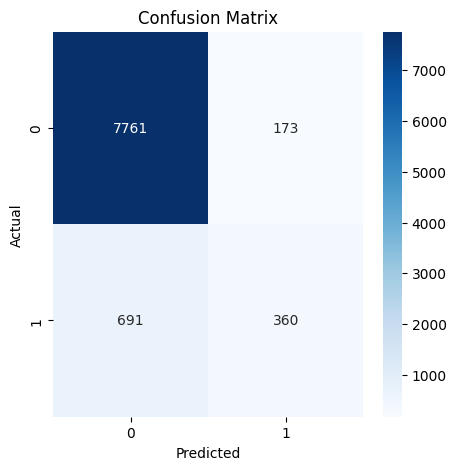

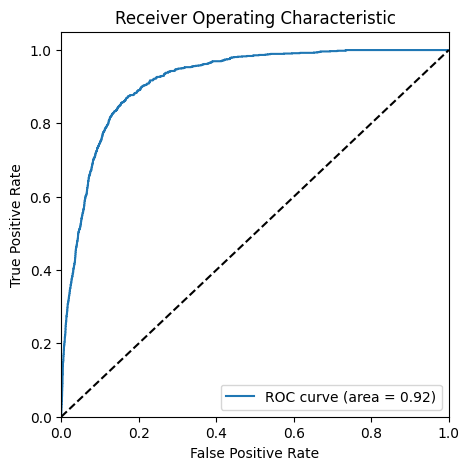

In [138]:
# random forest
rfc = RandomForestClassifier(random_state=42, n_estimators=150, max_depth=None, min_samples_split=10, min_samples_leaf=5, max_features='sqrt')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Random Forest Classifier')
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

XGBoost Classifier
Accuracy: 0.8967167501391208
Precision: 0.5734767025089605
Recall: 0.45670789724072314
F1 Score: 0.5084745762711864
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      7934
           1       0.57      0.46      0.51      1051

    accuracy                           0.90      8985
   macro avg       0.75      0.71      0.73      8985
weighted avg       0.89      0.90      0.89      8985



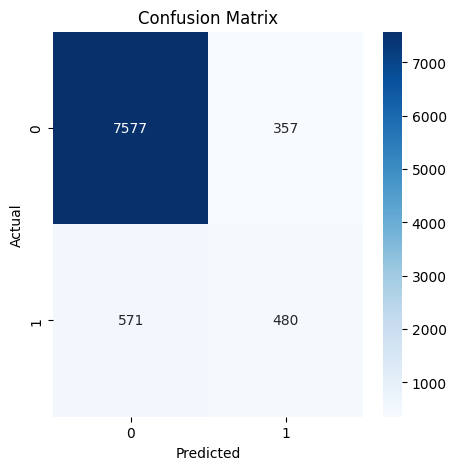

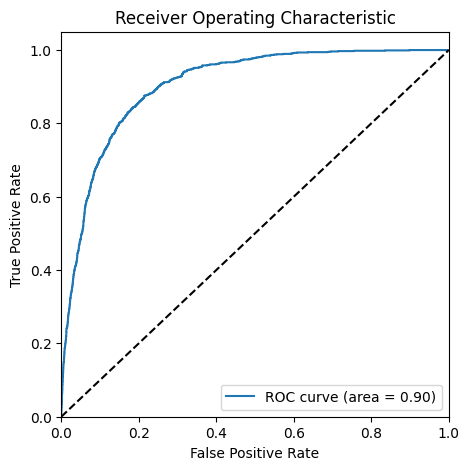

In [139]:
# xgboost
xgb = XGBClassifier(random_state=42, n_estimators=200, max_depth=30)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('XGBoost Classifier')
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Logistic Regression Classifier
Accuracy: 0.8996104618809126
Precision: 0.6313932980599647
Recall: 0.340627973358706
F1 Score: 0.44252163164400493
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7934
           1       0.63      0.34      0.44      1051

    accuracy                           0.90      8985
   macro avg       0.77      0.66      0.69      8985
weighted avg       0.88      0.90      0.89      8985



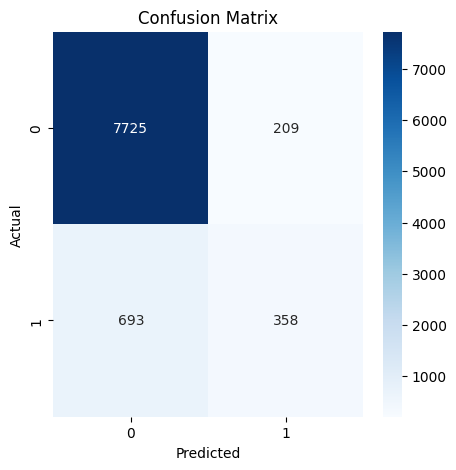

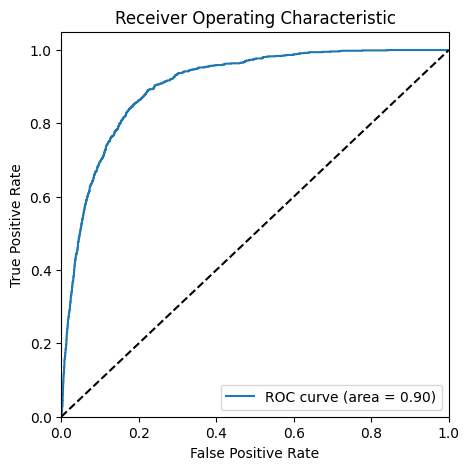

In [ ]:
# logistic regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Logistic Regression Classifier')
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Hyperparamter Tuning

In [ ]:
# Random‑Forest hyper‑parameter tuning with Optuna

# Objective function for Optuna
def rf_objective(trial):
    # Hyper‑parameter search space
    params = {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 500, step=50),
        "criterion"        : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth"        : trial.suggest_int("max_depth", 20, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 15),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 4, 8),
        "max_features"     : trial.suggest_float("max_features", 0.3, 0.6),
        "class_weight"     : {0:1,
                            1:trial.suggest_float("pos_weight", 3.0, 6.0)}
    }
    clf  = RandomForestClassifier(**params, n_jobs=-1, random_state=42)

    pipe = Pipeline([
        ("sm",  SMOTE(random_state=42, k_neighbors=3)),
        ("rf",  clf)
    ])

    cv   = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc  = cross_val_score(pipe, X_train, y_train, cv=cv,
                           scoring="roc_auc", n_jobs=-1).mean()
    return auc

# Optuna study
study = optuna.create_study(direction="maximize", study_name="RF_lead_scoring")
study.optimize(rf_objective, n_trials=10, show_progress_bar=True)

print("Best RF params:", study.best_params, " AUC:", study.best_value)

[I 2025-04-26 20:09:21,230] A new study created in memory with name: RF_lead_scoring


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-04-26 20:11:38,750] Trial 0 finished with value: 0.9076336194160968 and parameters: {'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 0.49891906137516634, 'pos_weight': 4.69753448084598}. Best is trial 0 with value: 0.9076336194160968.
[I 2025-04-26 20:14:06,056] Trial 1 finished with value: 0.9068482718153742 and parameters: {'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 0.5322226528304382, 'pos_weight': 4.630588390998291}. Best is trial 0 with value: 0.9076336194160968.
[I 2025-04-26 20:16:33,706] Trial 2 finished with value: 0.9051440072343265 and parameters: {'n_estimators': 400, 'criterion': 'gini', 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 0.5832232107793225, 'pos_weight': 3.653100355403182}. Best is trial 0 with value: 0.9076336194160968.
[I 2025-04-26 20:18:08,533] Trial 3 fini

In [142]:
# Xgboost hyper‑parameter tuning with Optuna

# Objective for Optuna
neg, pos = y_train.value_counts() # imbalance ratio
scale_pos = neg / pos

def xgb_objective(trial):
    params = {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 500, step=50),
        "max_depth"        : trial.suggest_int("max_depth", 12, 22),
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 0.05, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.55, 0.8),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.55, 0.8),
        "gamma"            : trial.suggest_float("gamma", 0.0, 1.0),
        "min_child_weight" : trial.suggest_int("min_child_weight", 3, 8),
        "scale_pos_weight" : trial.suggest_float("scale_pos_weight", 5.0, 8.0)
    }
    clf = XGBClassifier(**params,
                        objective='binary:logistic',
                        eval_metric='auc',
                        tree_method='hist',
                        random_state=42,
                        n_jobs=-1)

    pipe = Pipeline([("sm", SMOTE(random_state=42)), ("xgb", clf)])
    cv   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc  = cross_val_score(pipe, X_train, y_train, cv=cv,
                           scoring="roc_auc", n_jobs=-1).mean()
    return auc

# Optuna study
study_xgb = optuna.create_study(direction="maximize", study_name="XGB_lead_scoring")
study_xgb.optimize(xgb_objective, n_trials=20, show_progress_bar=True)

print("Best XGB params:", study_xgb.best_params, "AUC:", study_xgb.best_value)

[I 2025-04-26 20:33:27,765] A new study created in memory with name: XGB_lead_scoring


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-26 20:33:37,143] Trial 0 finished with value: 0.9055913084010818 and parameters: {'n_estimators': 500, 'max_depth': 18, 'learning_rate': 0.045117285280787324, 'subsample': 0.7870871189288985, 'colsample_bytree': 0.722373850723344, 'gamma': 0.5507871194957862, 'min_child_weight': 7, 'scale_pos_weight': 6.323210356635752}. Best is trial 0 with value: 0.9055913084010818.
[I 2025-04-26 20:33:44,910] Trial 1 finished with value: 0.9077017916331066 and parameters: {'n_estimators': 300, 'max_depth': 14, 'learning_rate': 0.018506441274387716, 'subsample': 0.5907162591484277, 'colsample_bytree': 0.5918310958938693, 'gamma': 0.7595720004530234, 'min_child_weight': 3, 'scale_pos_weight': 6.138619118155653}. Best is trial 1 with value: 0.9077017916331066.
[I 2025-04-26 20:33:53,160] Trial 2 finished with value: 0.9055241895256003 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.044754162694907076, 'subsample': 0.7477072847697248, 'colsample_bytree': 0.7873895311

XGBoost Classifier
Accuracy: 0.8871452420701169
Precision: 0.5122923588039867
Recall: 0.7335870599429115
F1 Score: 0.6032863849765259
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      7934
           1       0.51      0.73      0.60      1051

    accuracy                           0.89      8985
   macro avg       0.74      0.82      0.77      8985
weighted avg       0.91      0.89      0.90      8985



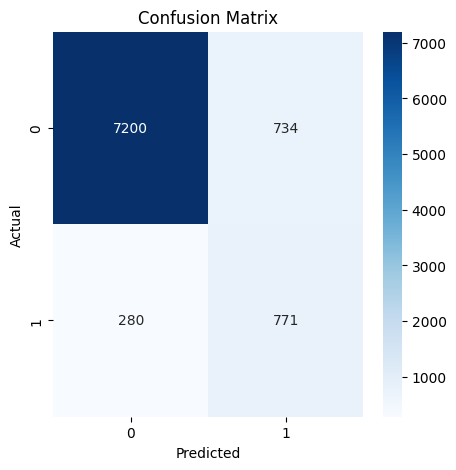

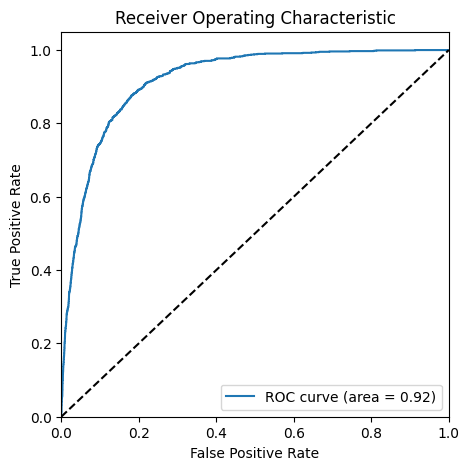

In [ ]:
# training entire set with best params
best_xgb = XGBClassifier(
    n_estimators=study_xgb.best_params["n_estimators"],
    max_depth=study_xgb.best_params["max_depth"],
    learning_rate=study_xgb.best_params["learning_rate"],
    subsample=study_xgb.best_params["subsample"],
    colsample_bytree=study_xgb.best_params["colsample_bytree"],
    gamma=study_xgb.best_params["gamma"],
    min_child_weight=study_xgb.best_params["min_child_weight"],
    scale_pos_weight=study_xgb.best_params["scale_pos_weight"],
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print('XGBoost Classifier')
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

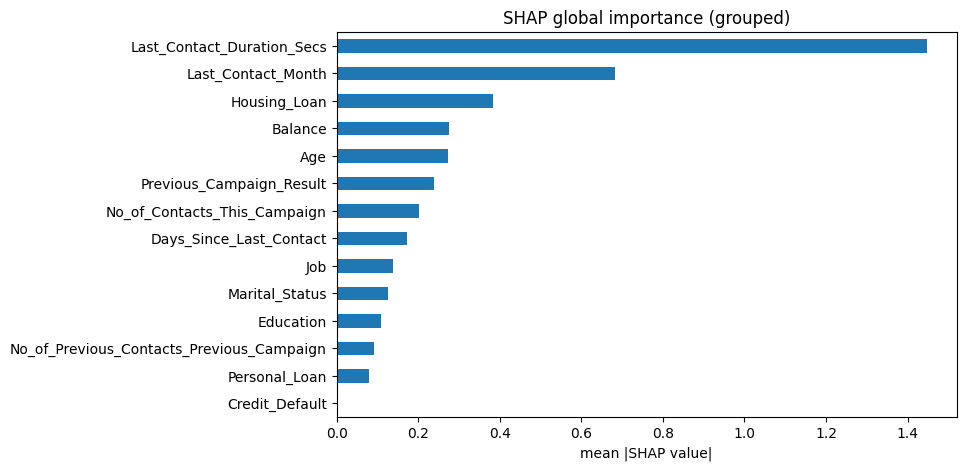

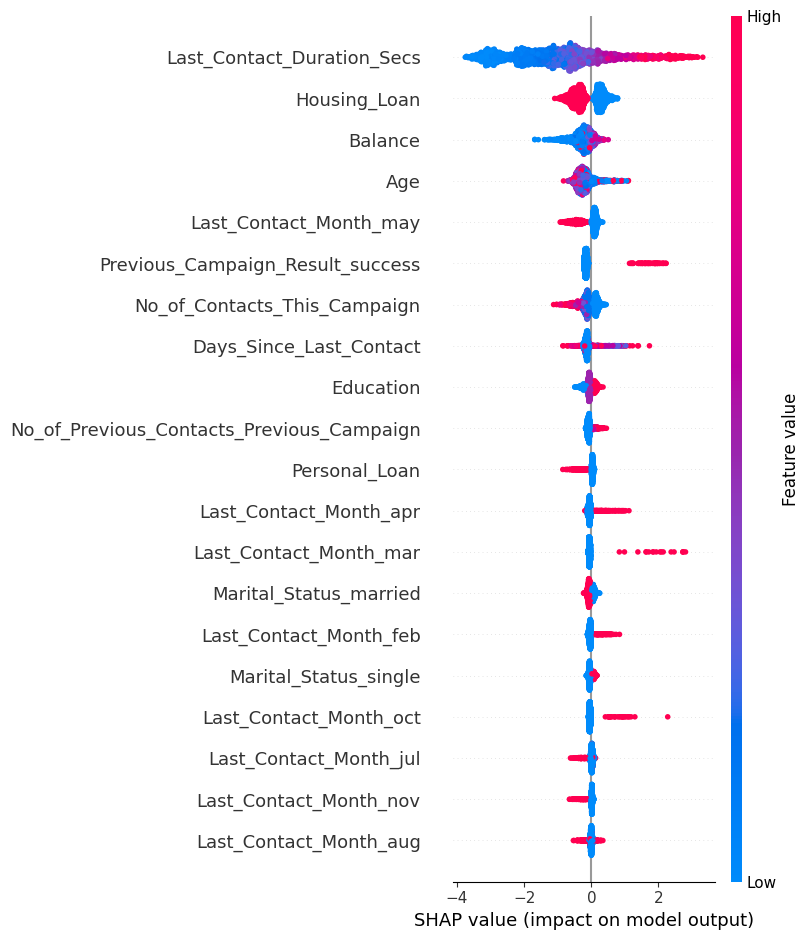

In [144]:
# SHAP analysis

X_test_enc = X_test.copy().astype(float)
X_smpl     = shap.sample(X_test_enc, 2000, random_state=42)


explainer   = shap.TreeExplainer(best_xgb, feature_perturbation="tree_path_dependent")
sv          = explainer.shap_values(X_smpl)


mean_abs = pd.Series(np.abs(sv).mean(axis=0), index=X_test_enc.columns)

# grouping dummy columns back
def parent(col):
    for p in ("Job_","Marital_Status_","Education_",
              "Last_Contact_Month_","Previous_Campaign_Result_"):
        if col.startswith(p): return p.rstrip("_")       
    return col                                           

grouped = (mean_abs
           .groupby([parent(c) for c in mean_abs.index])
           .sum()
           .sort_values(ascending=False))

# bar plot
plt.figure(figsize=(8,5))
grouped.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("SHAP global importance (grouped)")
plt.xlabel("mean |SHAP value|")
plt.show()

# beeswarm (with original dummies)
shap.summary_plot(sv, X_smpl, feature_names=X_test_enc.columns)
